In [1]:
import tensorflow as tf
import keras
import numpy as np
from mrc import mrcReader
import matplotlib.pyplot as plt
import pandas as pd
import keras
#import tifffile
#from libtiff import TIFF3D
from random import randint

%matplotlib inline

from cv_utils import *
from model import *
from train_utils import *


#Load raw cell data
cell_data = {}
cell_data[1] = mrcReader('data/Frank_ENCODE_255_33.rec')['stack']
cell_data[2] = mrcReader('data/Frank_ENCODE_255_34_resaved.rec')['stack']
cell_data[3] = mrcReader('data/Frank_ENCODE_249_2_iter50.rec')['stack']
#Renormalize
for i in xrange(1,4):
    cell_data[i]=cell_data[i]/cell_data[i].max()

#Load labels
cell_label = {}
cell_label[1] = np.load('data/common_255_33.npy')
cell_label[2] = np.load('data/common_255_34.npy')
cell_label[3] = np.load('data/common_249_2.npy')

no_cells = 3

in_cell_X = cell_data
in_cell_Y = {}
in_nucleus_X = {}
in_nucleus_Y = {}
simple_Y ={}

for i in xrange(1,no_cells+1):
    in_cell_Y[i] = cell_label[i] != 0
    in_nucleus_Y[i] = np.logical_or(cell_label[i] ==2,cell_label[i] == 3)
    simple_Y[i] = in_cell_Y[i].astype(int)+in_nucleus_Y[i].astype(int)
    in_nucleus_X[i] = cell_data[i]*in_cell_Y[i]
    in_nucleus_X[i] = in_nucleus_X[i]-in_nucleus_X[i].min()
    in_nucleus_X[i] = in_nucleus_X[i]/in_nucleus_X[i].max()


#Note that B- cell #3 has an unlabeled cell in the image, so we cannot 
#use B-cell #3 for cell detection training. Instead, we use it for CV 
#and will be careful to slice only from regions where the unlabelled cell
#is not present

in_cell_train = zip([in_cell_X[1],in_cell_X[2]],
                 [in_cell_Y[1],in_cell_Y[2]])
nucleus_train = zip([in_nucleus_X[1],in_nucleus_X[2]],
                    [in_nucleus_Y[1],in_nucleus_Y[2]])
simple_train = zip([cell_data[1],cell_data[2]],
                   [simple_Y[1],simple_Y[2]])
in_cell_cv = [(in_cell_X[3],in_cell_Y[3])]
in_nucleus_cv = [(in_nucleus_X[3],in_nucleus_Y[3])]




Using TensorFlow backend.


# Data description


Most models are trained on the human B-Cells. We have three labelled cells:
1) B-Cell 1: data/common_255_33.npy
2) B-Cell 2: data/common_255_34.npy
3) B-Cell 3: data/common_249.npy


Cell labels:

Label | Component | In cell | In nucleus
 --- | --- | --- | ---
 0 | Exterior | no | no 
 2 | Nucleus | yes | yes 
 3 | Nucleoli | yes | yes
 4 | Mitochondria | yes | no
 5 | ER | yes | no
 6 | Lipids | yes |no
 7 | Other | yes | no


# Cell detection model:

In [2]:
model = Skip_Cell_Model(no_labels = 2, opt='adadelta', pass_levels=[1,2,3,4])
model.load_weights('models/june14')

#this range is dominated by the labelled cell
small_X = in_cell_X[3][0:350,:,250:]
small_Y = in_cell_Y[3][0:350,:,250:]
cv_gen = slice_gen([(small_X,small_Y)], axes=[2], no_labels = 2)

train_gen = slice_gen(in_cell_train,batch_size=5,axes=[0,1,2],no_labels = 2)

In [3]:
#model.fit_generator(train_gen, validation_data = cv_gen, validation_steps = 10,
#        steps_per_epoch=40, epochs=60)

Accuracy is
0.992370605469


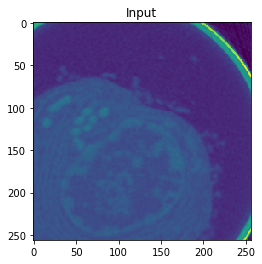

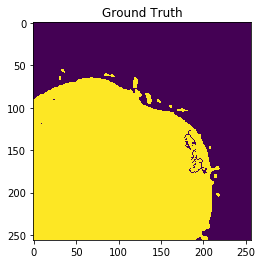

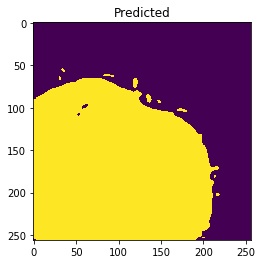

In [5]:
X,Y,Y_p = sample(model,train_gen)

In [3]:
acc, outliers = cross_validate(model, cv_gen)
acc.describe()

,0
count,100.000000
mean,0.965141
std,0.028759
min,0.900940
25%,0.943756
50%,0.967422
75%,0.993896
max,1.000000


Accuracy is
0.919204711914


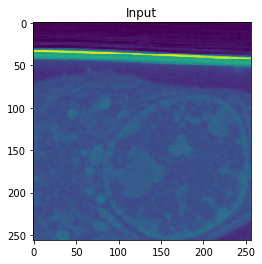

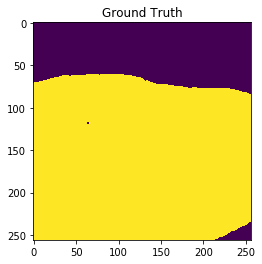

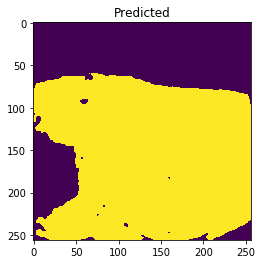

In [9]:
describe(*outliers[30])

# Nucleus detection

In [8]:
#nucleus detection model
model2 = Skip_Cell_Model(no_labels=2,opt='adadelta', pass_levels=[1,2,3,4])
model2.load_weights('models/june15_nucleus_fine')

Accuracy is
0.821075439453


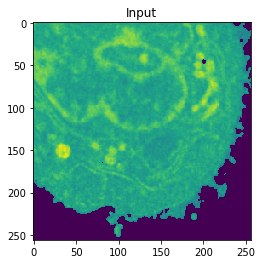

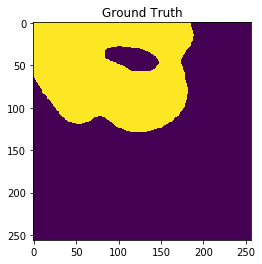

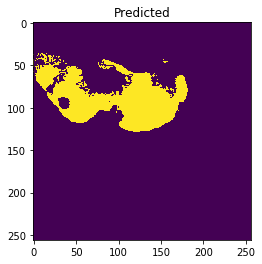

In [11]:
_, _, _ = sample(model2, non_zero_gen(zeroed_nucleus,axes=[1],no_labels=2,which_label=1))

# Low-resolution/smooth nucleus detection

In [12]:
type(zeroed_cell_data)

dict

In [13]:
model3 = SimpleCellModel(no_labels=2,opt='adadelta')
#model3.load_weights('june15_nucleus_coarse')
train_gen = non_zero_gen(zeroed_nucleus, batch_size = 5, 
                         axes = [0,1,2], no_labels =2,
                        which_label =1)
cv_gen = slice_gen([(zeroed_cell_data[3],in_nucleus_label[3])], 
                   axes = [0,1,2], no_labels = 2)


In [14]:
model3.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 40)

Epoch 1/40
40/40 [==============================] - 41s - loss: 0.8869 - categorical_accuracy: 0.8639 - val_loss: 0.3269 - val_categorical_accuracy: 0.8871
Epoch 2/40
40/40 [==============================] - 36s - loss: 0.2573 - categorical_accuracy: 0.8823 - val_loss: 0.0832 - val_categorical_accuracy: 0.9582
Epoch 3/40
40/40 [==============================] - 36s - loss: 0.2349 - categorical_accuracy: 0.8829 - val_loss: 0.1056 - val_categorical_accuracy: 0.9436
Epoch 4/40
40/40 [==============================] - 36s - loss: 0.2170 - categorical_accuracy: 0.9031 - val_loss: 0.6028 - val_categorical_accuracy: 0.8073
Epoch 5/40
40/40 [==============================] - 36s - loss: 0.1857 - categorical_accuracy: 0.9158 - val_loss: 0.1410 - val_categorical_accuracy: 0.9539
Epoch 6/40
40/40 [==============================] - 36s - loss: 0.1291 - categorical_accuracy: 0.9458 - val_loss: 0.4099 - val_categorical_accuracy: 0.9597
Epoch 7/40
40/40 [==============================] - 36s - loss: 

Accuracy is
0.982482910156


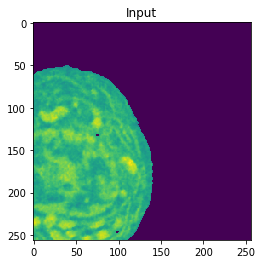

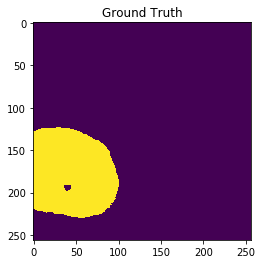

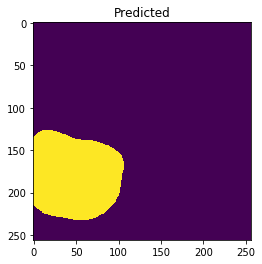

In [141]:
X,Y,Y_p = sample(model3,non_zero(cv_gen))

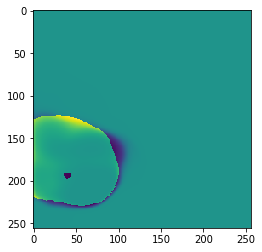

In [142]:
plt.imshow(Y[0,:,:,1]-Y_p[0,:,:,1])

In [123]:
model3.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 40)

Epoch 1/40
40/40 [==============================] - 35s - loss: 0.0326 - categorical_accuracy: 0.9871 - val_loss: 0.0645 - val_categorical_accuracy: 0.9754
Epoch 2/40
40/40 [==============================] - 35s - loss: 0.0343 - categorical_accuracy: 0.9865 - val_loss: 0.0804 - val_categorical_accuracy: 0.9745
Epoch 3/40
40/40 [==============================] - 36s - loss: 0.0369 - categorical_accuracy: 0.9859 - val_loss: 0.0284 - val_categorical_accuracy: 0.9909
Epoch 4/40
40/40 [==============================] - 36s - loss: 0.0319 - categorical_accuracy: 0.9873 - val_loss: 0.0496 - val_categorical_accuracy: 0.9815
Epoch 5/40
40/40 [==============================] - 36s - loss: 0.0334 - categorical_accuracy: 0.9871 - val_loss: 0.0425 - val_categorical_accuracy: 0.9877
Epoch 6/40
40/40 [==============================] - 36s - loss: 0.0300 - categorical_accuracy: 0.9881 - val_loss: 0.0237 - val_categorical_accuracy: 0.9888
Epoch 7/40
40/40 [==============================] - 36s - loss: 

Accuracy is
0.848342895508


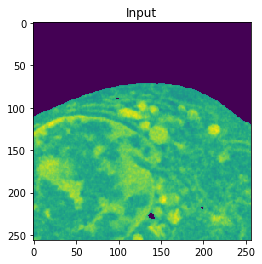

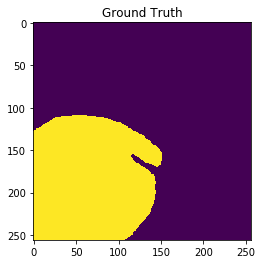

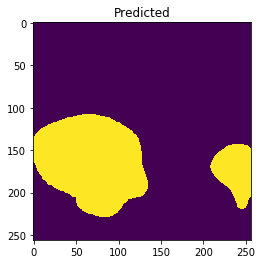

In [143]:
acc, _ = cross_validate(model3,cv_gen, outlier_cut=.86)

In [144]:
acc.describe()

,0
count,100.000000
mean,0.984537
std,0.025177
min,0.848343
25%,0.979931
50%,1.000000
75%,1.000000
max,1.000000


# Nucleus with optional pass-throughs


In [49]:
model4 = Passthrough_Cell_Model(no_labels=2,opt='adadelta',pass_levels=[4])
train_gen = non_zero_gen(zeroed_nucleus, batch_size = 5, 
                         axes = [0,1,2], no_labels =2,
                        which_label =1)
cv_gen = slice_gen([(zeroed_cell_data[3],in_nucleus_label[3])], 
                   axes = [0,1,2], no_labels = 2)

In [50]:
model4.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 20)

Epoch 1/20
40/40 [==============================] - 39s - loss: 0.3858 - categorical_accuracy: 0.8587 - val_loss: 0.4753 - val_categorical_accuracy: 0.8406
Epoch 2/20
40/40 [==============================] - 38s - loss: 0.1930 - categorical_accuracy: 0.8777 - val_loss: 0.4579 - val_categorical_accuracy: 0.9532
Epoch 3/20
40/40 [==============================] - 38s - loss: 0.1830 - categorical_accuracy: 0.9242 - val_loss: 0.1698 - val_categorical_accuracy: 0.9137
Epoch 4/20
40/40 [==============================] - 38s - loss: 0.1416 - categorical_accuracy: 0.9401 - val_loss: 0.1445 - val_categorical_accuracy: 0.9157
Epoch 5/20
40/40 [==============================] - 38s - loss: 0.1561 - categorical_accuracy: 0.9283 - val_loss: 0.1114 - val_categorical_accuracy: 0.9742
Epoch 6/20
40/40 [==============================] - 38s - loss: 0.1474 - categorical_accuracy: 0.9423 - val_loss: 0.0753 - val_categorical_accuracy: 0.9794
Epoch 7/20
40/40 [==============================] - 38s - loss: 

In [60]:
model4.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 20)

Epoch 1/20
40/40 [==============================] - 37s - loss: 0.0373 - categorical_accuracy: 0.9871 - val_loss: 0.5063 - val_categorical_accuracy: 0.9567
Epoch 2/20
40/40 [==============================] - 37s - loss: 0.0425 - categorical_accuracy: 0.9843 - val_loss: 0.2106 - val_categorical_accuracy: 0.9621
Epoch 3/20
40/40 [==============================] - 37s - loss: 0.0490 - categorical_accuracy: 0.9816 - val_loss: 0.4030 - val_categorical_accuracy: 0.9435
Epoch 4/20
40/40 [==============================] - 38s - loss: 0.0433 - categorical_accuracy: 0.9842 - val_loss: 0.0370 - val_categorical_accuracy: 0.9843
Epoch 5/20
40/40 [==============================] - 38s - loss: 0.0462 - categorical_accuracy: 0.9821 - val_loss: 0.0078 - val_categorical_accuracy: 0.9975
Epoch 6/20
40/40 [==============================] - 38s - loss: 0.0384 - categorical_accuracy: 0.9859 - val_loss: 0.4197 - val_categorical_accuracy: 0.9688
Epoch 7/20
40/40 [==============================] - 38s - loss: 

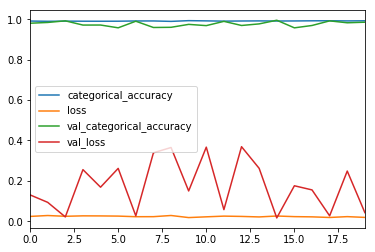

In [124]:
pd.DataFrame(model4.history.history).plot()

In [103]:
model4.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 20)

Epoch 1/20
40/40 [==============================] - 37s - loss: 0.0235 - categorical_accuracy: 0.9911 - val_loss: 0.1301 - val_categorical_accuracy: 0.9803
Epoch 2/20
40/40 [==============================] - 37s - loss: 0.0280 - categorical_accuracy: 0.9899 - val_loss: 0.0932 - val_categorical_accuracy: 0.9841
Epoch 3/20
40/40 [==============================] - 37s - loss: 0.0242 - categorical_accuracy: 0.9906 - val_loss: 0.0210 - val_categorical_accuracy: 0.9921
Epoch 4/20
40/40 [==============================] - 37s - loss: 0.0263 - categorical_accuracy: 0.9902 - val_loss: 0.2552 - val_categorical_accuracy: 0.9711
Epoch 5/20
40/40 [==============================] - 38s - loss: 0.0260 - categorical_accuracy: 0.9901 - val_loss: 0.1683 - val_categorical_accuracy: 0.9713
Epoch 6/20
40/40 [==============================] - 38s - loss: 0.0251 - categorical_accuracy: 0.9903 - val_loss: 0.2614 - val_categorical_accuracy: 0.9576
Epoch 7/20
40/40 [==============================] - 38s - loss: 

Accuracy is
0.991836547852


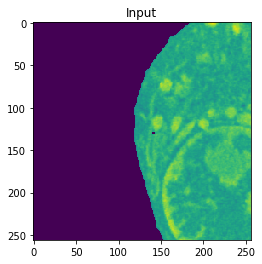

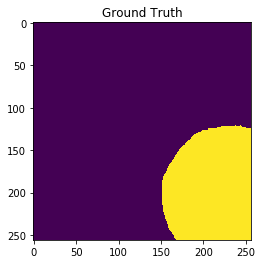

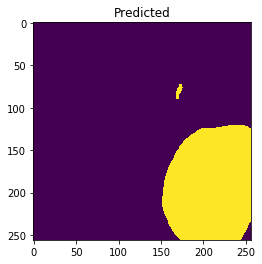

In [112]:
def non_zero(cv_gen):
    while 1:
        X,Y = next(cv_gen)
        while np.sum(Y[:,:,:,1])<20:
            X,Y = next(cv_gen)
        yield (X,Y)

X,Y,Y_p = sample(model4,non_zero(cv_gen))

Accuracy is
0.930465698242
Accuracy is
0.945709228516
Accuracy is
0.923904418945
Accuracy is
0.936431884766
Accuracy is
0.919219970703
Accuracy is
0.891952514648
Accuracy is
0.936019897461
Accuracy is
0.948745727539
Accuracy is
0.944061279297


,0
count,100.000000
mean,0.977324
std,0.018571
min,0.891953
25%,0.972214
50%,0.984055
75%,0.989265
max,0.997604


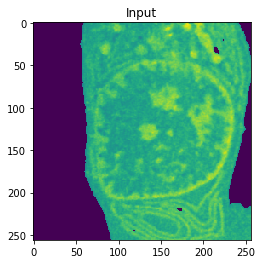

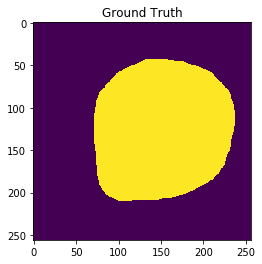

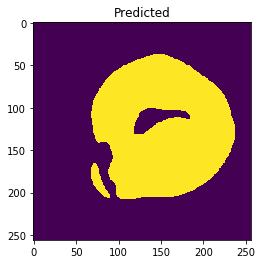

In [145]:
acc, outliers = cross_validate(model3, non_zero(cv_gen))
acc.describe()

In [146]:
model4.fit_generator(train_gen, validation_data = cv_gen, 
                    validation_steps = 10,
                    steps_per_epoch =40,
                    epochs = 20)

Epoch 1/20
40/40 [==============================] - 37s - loss: 0.0224 - categorical_accuracy: 0.9915 - val_loss: 0.6862 - val_categorical_accuracy: 0.9505
Epoch 2/20
40/40 [==============================] - 37s - loss: 0.0217 - categorical_accuracy: 0.9921 - val_loss: 0.1655 - val_categorical_accuracy: 0.9645
Epoch 3/20
40/40 [==============================] - 37s - loss: 0.0204 - categorical_accuracy: 0.9922 - val_loss: 0.0436 - val_categorical_accuracy: 0.9842
Epoch 4/20
40/40 [==============================] - 38s - loss: 0.0231 - categorical_accuracy: 0.9914 - val_loss: 0.1485 - val_categorical_accuracy: 0.9847
Epoch 5/20
40/40 [==============================] - 38s - loss: 0.0235 - categorical_accuracy: 0.9910 - val_loss: 0.2824 - val_categorical_accuracy: 0.9548
Epoch 6/20
40/40 [==============================] - 38s - loss: 0.0192 - categorical_accuracy: 0.9924 - val_loss: 0.1954 - val_categorical_accuracy: 0.9771
Epoch 7/20
40/40 [==============================] - 38s - loss: 

Accuracy is
0.894470214844
Accuracy is
0.872695922852


,0
count,100.000000
mean,0.973827
std,0.022561
min,0.872696
25%,0.967651
50%,0.982750
75%,0.987484
max,0.997162


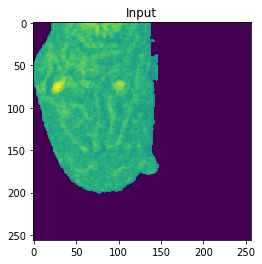

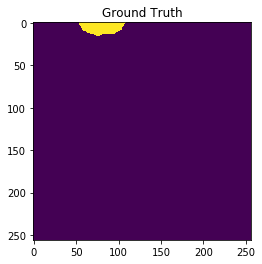

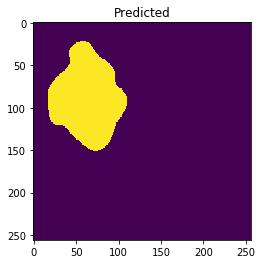

In [150]:
acc, outliers = cross_validate(model3, non_zero(cv_gen), outlier_cut=.9)
acc.describe()

# Model evaluation and debugging

In [117]:
def cross_validate(model, cv_gen, no_samples = 100, outlier_cut = .95):
    accuracy_list = []
#cv_list = zip([cell_3],[simple_label_3])
    c =1
    slice_list = []
    outliers = []
    for _ in xrange(no_samples):
        X_t,Y_t = next(cv_gen)
        Y_pred = model.predict(X_t)
        Y_pred_im = Y_pred.argmax(3)
        Y_im = Y_t.argmax(3)
        accuracy = np.sum(Y_im == Y_pred_im)/(256*256.)
        accuracy_list.append(accuracy)
        slice_list.append((X_t,Y_t,Y_pred))
        if accuracy < outlier_cut:
            describe(X_t,Y_t,Y_pred)

    acc = pd.DataFrame(accuracy_list)
    return(acc, outliers)


Accuracy is
0.948806762695


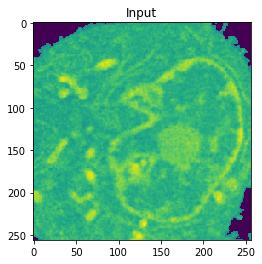

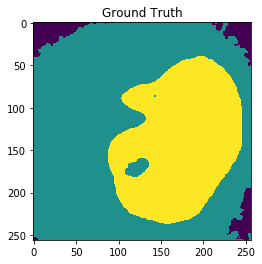

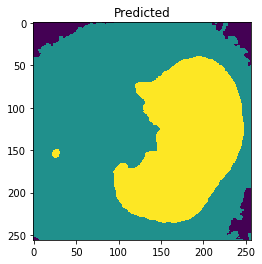

In [37]:
X,Y,Y_pred = outliers[0]
describe(X,Y,Y_pred)

In [75]:
from libtiff import TIFF3D
Olfactory = {}
Olfactory[1] =  mrcReader('Olfactory1.rec')['stack']
Olfactory[2] = mrcReader('Olfactory2.rec')['stack']
Olfactory[3] = mrcReader('Olfactory3.rec')['stack']

Olfactory_labels = {}

tif = TIFF3D.open('Olfactory1.tif', mode='r')
Olfactory_labels[1] = tif.read_image()

tif = TIFF3D.open('Olfactory2.tif', mode='r')
Olfactory_labels[2] = tif.read_image()

tif = TIFF3D.open('Olfactory3.tif', mode='r')
Olfactory_labels[3] = tif.read_image()


In [ ]:
3

In [76]:
in_Olfactory = {}
for i in xrange(1,4):
    in_Olfactory[i] = Olfactory_labels[i] != 0
    Olfactory[i] = Olfactory[i]/Olfactory[i].max()

cv_list = zip([Olfactory[i] for i in xrange(1,4)],[in_Olfactory[i] for i in xrange(1,4)])

0.959686994553
Accuracy is
0.98388671875


(10, 256, 256, 1)

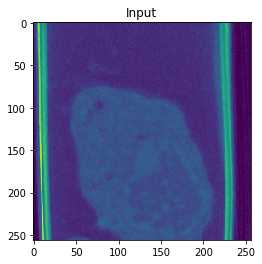

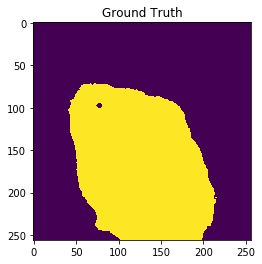

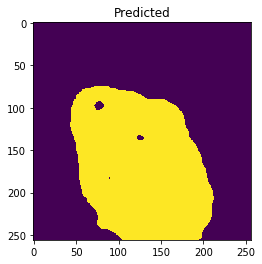

In [68]:
import time
X,Y = next(slice_gen(cv_list, axes = [0,1,2], batch_size=10,no_labels=2))
t=time.time()        
Y_pred = model.predict(X)
print(time.time()-t)
describe(X,Y,Y_pred)



# Recovering stack

In [17]:
def binary_predict(data, model, stride):

    #for each axis, we make predictions along sliding windows
    #at the end of the prediction, we sum results, take maxarg
    #note that it will take .11 seconds for each prediction
    #each slice will be approximatey .44 seconds
    #thus a stack will take 3*.44*400 seconds, or 8.8 minutes
    M,N,P = data.shape
    predict = np.zeros((M,N,P,2))
    window = np.zeros([1,256,256,1])
    for z in xrange(M):
        for i in xrange((N-256)/stride+1):
            for j in xrange((P-256)/stride+1):
                x=stride*i
                y=stride*j
                window[0,:,:,0] = data[z,x:x+256,y:y+256]
                predict[z,x:x+256,y:y+256,:] += model.predict(window)[0,:,:,:]
    predict_labels = predict.argmax(3)
    return predict_labels


In [95]:
t=time.time()
predict_stack_4 = cell_predict(cell_data[1],model,100)
print time.time()-t

178.831892014


In [97]:
predict_stack.shape

(512, 386, 395)

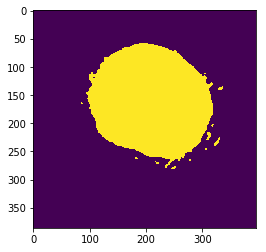

In [96]:
plt.imshow(predict_stack_4[200,:,:])

In [99]:
np.sum(predict_stack ==in_cell_label[1])/(512.0*386*395)

0.95829126990145608

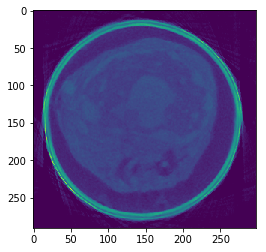

In [103]:
plt.imshow(Olfactory[3][250,:,:])

In [104]:
test_cell = cell_data[1].swapaxes(0,1)

In [105]:
test_cell.shape

(386, 512, 395)

In [107]:
test_predict = cell_predict(test_cell,model,100)

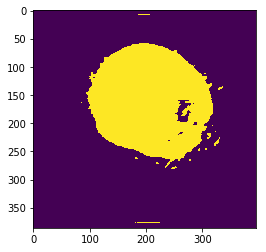

In [109]:
plt.imshow(test_predict[:,200,:])

In [110]:
test_labels = in_cell_label[1].swapaxes(0,1)

In [111]:
np.sum(test_predict == test_labels)/(512.0*386*395)

0.99508389457762181

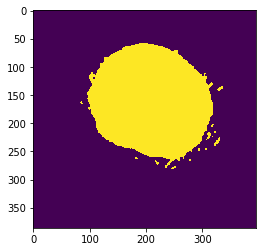

In [112]:
plt.imshow(test_labels[:,200,:])

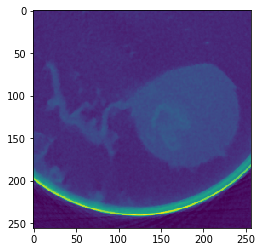

In [64]:
plt.imshow(cell_data[3][18,150:406,100:356])

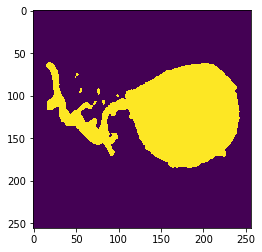

In [66]:
Y = cell_label[3][18,150:406,100:356] != 0
plt.imshow(Y)

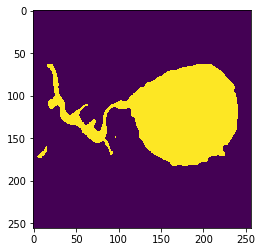

In [65]:
X = np.zeros((1,256,256,1))
X[0,:,:,0] = cell_data[3][18,150:406,100:356]
Y_p = model.predict(X)[0,:,:,:].argmax(2)
plt.imshow(Y_p)

In [68]:
X = np.zeros((1,256,256,1))
acc = []
pairs =[]
for i in xrange(100):
    X[0,:,:,0] = cell_data[3][i,150:406,100:356]
    Y = cell_label[3][i,150:406,100:356] != 0
    Y_p = model.predict(X)[0,:,:,:].argmax(2)
    pairs.append((Y,Y_p))
    acc.append(np.sum(Y == Y_p)/(256.*256))
    

In [73]:
acc_data = pd.DataFrame(acc)
acc_data.describe()
acc_data[acc_data[0]<.97]

,0
0,0.967255
1,0.969452
3,0.967484
4,0.964737
5,0.959702
6,0.956924
7,0.956329
8,0.957321
9,0.954971
10,0.955231


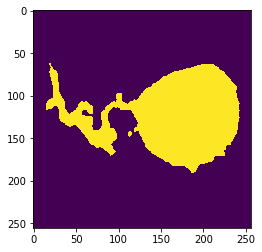

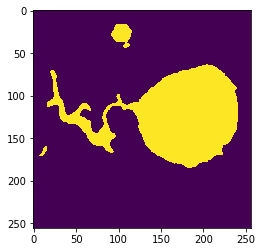

In [74]:
Y,Y_p = pairs[15]
plt.figure(1)
plt.imshow(Y)

plt.figure(2)
plt.imshow(Y_p)

In [77]:
Olfactory[2].shape

(512, 292, 279)

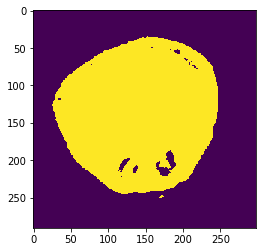

In [109]:
plt.imshow(in_Olfactory[3][250,:,:])

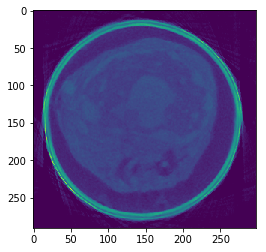

In [108]:
plt.imshow(Olfactory[3][250,:,:])

In [110]:
X = np.zeros((1,256,256,1))
acc_2 = []
pairs_2 =[]
for i in xrange(100):
    X[0,:,:,0] = Olfactory[3][i+90,20:276,20:276]
    Y = cell_label[3][i,150:406,100:356] != 0
    Y_p = model.predict(X)[0,:,:,:].argmax(2)
    pairs_2.append((Y,Y_p))
    acc_2.append(np.sum(Y == Y_p)/(256.*256))


In [111]:
acc_2_frame = pd.DataFrame(acc_2)
acc_2_frame.describe()


,0
count,100.000000
mean,0.709240
std,0.054274
min,0.642914
25%,0.670021
50%,0.692192
75%,0.733452
max,0.847183


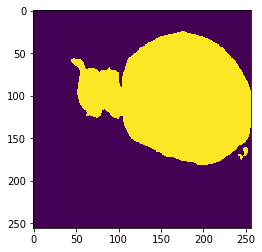

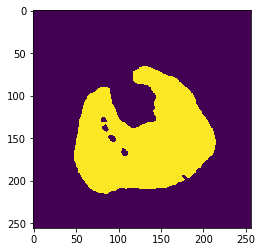

In [112]:
Y,Y_p = pairs_2[80]
plt.figure(1)
plt.imshow(Y)

plt.figure(2)
plt.imshow(Y_p)

In [113]:
data = mrcReader('Olfactory1.rec')

In [114]:
data

{'axisOrientations': array([1, 2, 3], dtype=int32),
 'filename': 'Olfactory1.rec',
 'stack': array([[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            1.80471479e-03,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            6.09867799e-04,   0.00000000e+00,   1.02906041e-02],
         ..., 
         [  0.00000000e+00,   2.86583346e-03,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   1.51943993e-02, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00]],
 
        [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.000

In [115]:
data2 = mrcReader('Frank_ENCODE_255_33.rec')

In [116]:
data2['voxelSize']

array([ 0.00253165,  0.00259067,  0.00195312], dtype=float32)

In [117]:
mrcReader('Olfactory1.rec')['voxelSize']

array([ 1.,  1.,  1.], dtype=float32)